# Understanding variation in lifespans of notable people using the BHHT data

The [BHHT](https://medialab.github.io/bhht-datascape) (Brief History of Human Time) project provides a dataset about "notable people" based mainly on wikipedia biography articles.

The analyses below focus on lifespans of the people in the BHHT dataset, aiming to understand how lifespans vary based on factors including era of birth, the geographic region where the person lived, and the person's sex.

This analysis uses survival analysis methods, allowing us to use information from still-living people.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path
from scipy.stats.distributions import chi2

Change the path below as needed to point to the directory containing the data file.

In [2]:
pa = Path("/Users/jiatao/Desktop/UMich/25Fall/STATS 485/case2/")

Load the dataset.  Use the latin-1 encoding since there is some non-UTF data in the file.  Add "nrows=####" when developing to reduce the run time, but always use the complete data to get final results.

In [3]:
df = pd.read_csv(pa / Path("cross-verified-database.csv.gz"), encoding="latin-1")

In [4]:
df.shape

(2291817, 49)

Create a lifespan variable (years of life).  It will be missing for people who are currently living.

In [5]:
df["lifespan"] = df["death"] - df["birth"]

            Count  Percent  Death Rate %  Cumulative %
Before 0     1902     0.09         73.82          0.09
0-999        8247     0.39         81.19          0.48
1000-1600   51031     2.43         96.52          2.91
1601-1700   36053     1.72         98.40          4.63
1701-1800   94519     4.51         98.44          9.14
1801-1900  417227    19.91         97.67         29.05
1901-1960  805573    38.44         48.98         67.49
1961-2018  681346    32.51          2.14        100.00


/var/folders/hh/049t2rhs1hd6bl2y2zk8_j980000gn/T/ipykernel_25807/2893743734.py:19: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  death_rate = df.groupby("birth_bin")["lifespan"].apply(lambda x: x.notna().mean() * 100)


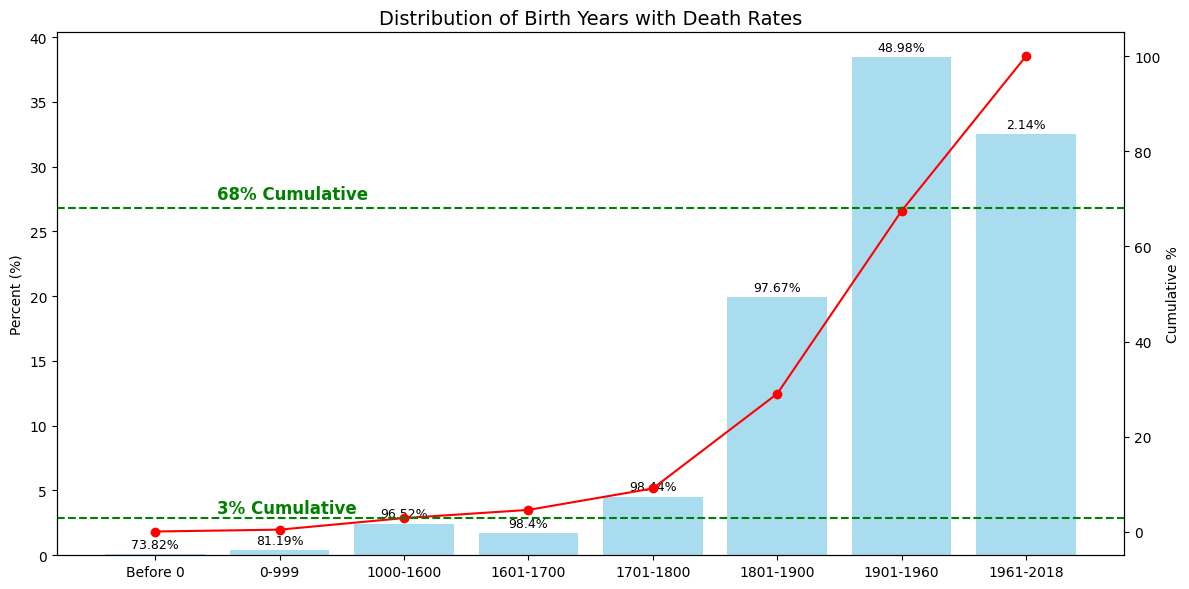

In [6]:
birth_years = df["birth"].dropna().astype(int)
max_year = birth_years.max()

bins = [-float("inf"), 0, 1000, 1601] 
labels = ["Before 0", "0-999", "1000-1600"]

bins.extend([1701, 1801, 1901])
labels.extend([f"{b}-{b+99}" for b in [1601, 1701, 1801]])

bins.extend([1961, max_year + 1])
labels.extend(["1901-1960", f"1961-{max_year}"])

birth_groups = pd.cut(birth_years, bins=bins, labels=labels, right=False)

group_counts = birth_groups.value_counts().sort_index()
group_percent = group_counts / group_counts.sum() * 100

df["birth_bin"] = pd.cut(df["birth"], bins=bins, labels=labels, right=False)
death_rate = df.groupby("birth_bin")["lifespan"].apply(lambda x: x.notna().mean() * 100)

result = pd.DataFrame({
    "Count": group_counts,
    "Percent": group_percent.round(2),
    "Death Rate %": death_rate.round(2)
})
result["Cumulative %"] = result["Percent"].cumsum().round(2)

print(result)

fig, ax1 = plt.subplots(figsize=(12,6))

ax1.bar(result.index, result["Percent"], label="Percent", alpha=0.7, color="skyblue")
ax1.set_ylabel("Percent (%)")

ax2 = ax1.twinx()
ax2.plot(result.index, result["Cumulative %"], color="red", marker="o", label="Cumulative %")
ax2.set_ylabel("Cumulative %")

ax2.axhline(3, color="green", linestyle="--", linewidth=1.5, label="3% threshold")

ax2.text( x=0.5, y=4, s="3% Cumulative", color="green", fontsize=12, fontweight="bold")

ax2.axhline(68, color="green", linestyle="--", linewidth=1.5, label="68% threshold")

ax2.text( x=0.5, y=70, s="68% Cumulative", color="green", fontsize=12, fontweight="bold")

for i, (idx, row) in enumerate(result.iterrows()):
    ax1.text(i, row["Percent"] + 0.5, f"{row['Death Rate %']}%", 
             ha="center", fontsize=9, color="black")

plt.title("Distribution of Birth Years with Death Rates", fontsize=14)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


In [7]:
df.query("birth <= 1600").un_region.value_counts()

un_region
Europe     46950
Asia        7936
Africa       738
America      573
Oceania        1
Name: count, dtype: int64

In [8]:
df.query("birth <= 1600").shape

(61180, 51)

In [9]:
df.query("birth <= 1600").level1_main_occ.value_counts()

level1_main_occ
Leadership           37203
Culture              11301
Discovery/Science     7529
Other                 3834
Missing               1139
Sports/Games           174
Name: count, dtype: int64

In [ ]:
df.query("1600 <= birth <= 1960").bplo1.value_counts()

all_geography_groups
US                                                           218255
Germany                                                      148058
France                                                        98289
United_Kingdom_of_Great_Britain_and_Northern_Ireland          63626
Italy                                                         45949
                                                              ...  
Old_regimes_in_/_of_Russia,US,Finland                             1
Austria-Hungary,Poland,Former_Soviet_Union,Poland,Poland          1
Switzerland,Ireland                                               1
Poland,France,US,Israel                                           1
Principality_of_Anhalt-Zerbst,Old_regimes_in_/_of_Germany         1
Name: count, Length: 5313, dtype: int64

In [10]:
dx = df.query("1600 <= birth <= 1960")

Retain only variables to be analyzed below.

In [11]:
dx.columns

Index(['wikidata_code', 'birth', 'death', 'updated_death_date', 'approx_birth',
       'approx_death', 'birth_min', 'birth_max', 'death_min', 'death_max',
       'gender', 'level1_main_occ', 'name', 'un_subregion', 'birth_estimation',
       'death_estimation', 'bigperiod_birth_graph_b',
       'bigperiod_death_graph_b', 'curid', 'level2_main_occ', 'freq_main_occ',
       'freq_second_occ', 'level2_second_occ', 'level3_main_occ',
       'bigperiod_birth', 'bigperiod_death', 'wiki_readers_2015_2018',
       'non_missing_score', 'total_count_words_b', 'number_wiki_editions',
       'total_noccur_links_b', 'sum_visib_ln_5criteria',
       'ranking_visib_5criteria', 'all_geography_groups',
       'string_citizenship_raw_d', 'citizenship_1_b', 'citizenship_2_b',
       'list_areas_of_rattach', 'area1_of_rattachment', 'area2_of_rattachment',
       'list_wikipedia_editions', 'un_region', 'group_wikipedia_editions',
       'bplo1', 'dplo1', 'bpla1', 'dpla1', 'pantheon_1', 'level3_all_occ',
  

In [12]:
dx = dx[["birth", "lifespan", "level1_main_occ", "un_region"]]
dx.head()

,birth,lifespan,level1_main_occ,un_region
0,1932.0,58.0,Culture,Europe
1,1860.0,67.0,Culture,Europe
4,1912.0,65.0,Leadership,Europe
5,1928.0,88.0,Culture,America
6,1818.0,76.0,Discovery/Science,Europe


In [13]:
print(dx.level1_main_occ.value_counts())

level1_main_occ
Leadership           451255
Culture              428970
Sports/Games         216372
Discovery/Science    216212
Other                 31819
Missing                9487
Name: count, dtype: int64


In [14]:
dx = dx.loc[dx["level1_main_occ"].isin(["Leadership", "Culture", "Discovery/Science", "Sports/Games"]), :]

In [15]:
print(dx.un_region.value_counts())

un_region
Europe     779447
America    363808
Asia        82162
Oceania     45098
Africa      22869
Name: count, dtype: int64


Censor lifespans at the last year when anyone died in the dataset.

In [16]:
censor_year = df["death"].max()
print("Censoring at %d" % censor_year)
dx["clifespan"] = dx["lifespan"].fillna(censor_year - dx["birth"])
dx["died"] = 1 - 1*dx["lifespan"].isnull()
print(dx.shape)
dx.head()

Censoring at 2020
(1312809, 6)


,birth,lifespan,level1_main_occ,un_region,clifespan,died
0,1932.0,58.0,Culture,Europe,58.0,1
1,1860.0,67.0,Culture,Europe,67.0,1
4,1912.0,65.0,Leadership,Europe,65.0,1
5,1928.0,88.0,Culture,America,88.0,1
6,1818.0,76.0,Discovery/Science,Europe,76.0,1


Now we can drop all rows with missing data

In [17]:
dx = dx.drop("lifespan", axis=1)
dx = dx.dropna()
print(dx.shape)
dx.head()

(1293384, 5)


,birth,level1_main_occ,un_region,clifespan,died
0,1932.0,Culture,Europe,58.0,1
1,1860.0,Culture,Europe,67.0,1
4,1912.0,Leadership,Europe,65.0,1
5,1928.0,Culture,America,88.0,1
6,1818.0,Discovery/Science,Europe,76.0,1


Calculate the proportion of people who have died (so their lifespans are known).  This is not a valid parameter for our longevity analysis, since it is largely dependent on the distribution of birth years.

In [18]:
dx["died"].mean()

np.float64(0.6827492840486661)

Create a categorical variable indicating the century in which a person was born.

In [19]:
dx["era"] = np.floor((dx["birth"] - 1600) / 100)
dx.head()

,birth,level1_main_occ,un_region,clifespan,died,era
0,1932.0,Culture,Europe,58.0,1,3.0
1,1860.0,Culture,Europe,67.0,1,2.0
4,1912.0,Leadership,Europe,65.0,1,3.0
5,1928.0,Culture,America,88.0,1,3.0
6,1818.0,Discovery/Science,Europe,76.0,1,2.0


In [20]:
dx["era"].value_counts()

era
3.0    788583
2.0    388871
1.0     84116
0.0     31814
Name: count, dtype: int64

## Marginal survival functions

Below we plot the marginal survival functions for people born in each century.  These survival functions are estimated using the product limit (Kaplan-Meier) method.  Note that the curve for 1900 suggests that 10% of notable people live to be 100.  This is unlikely to be true, and could be due to improvements in health within the 20th century -- people born later in the 20th century are (by construction) more likely to be censored and also presumably have longer lifespans.  This results in dependent censoring, which biases the survival function estimates.

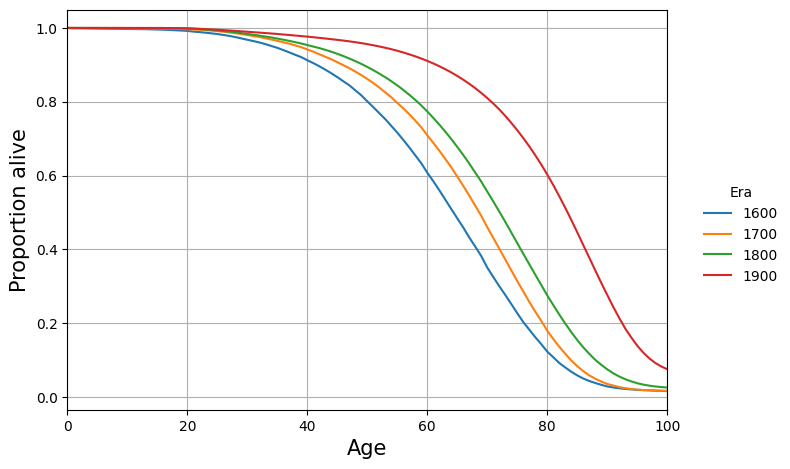

In [21]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("era"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    la = "%.0f" % (1600 + k*100)
    plt.plot(sf.surv_times, sf.surv_prob, label=la)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right", title="Era")
leg.draw_frame(False)

We can also estimate the marginal survival function for each occupation and for each region.

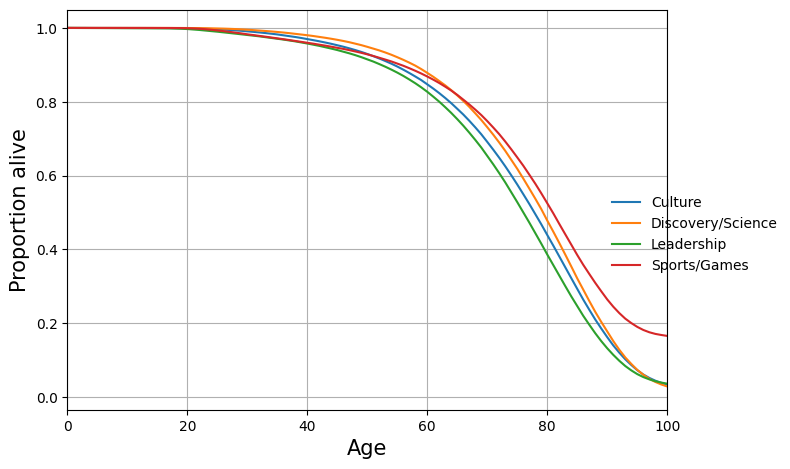

In [22]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("level1_main_occ"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.surv_prob, label=k)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

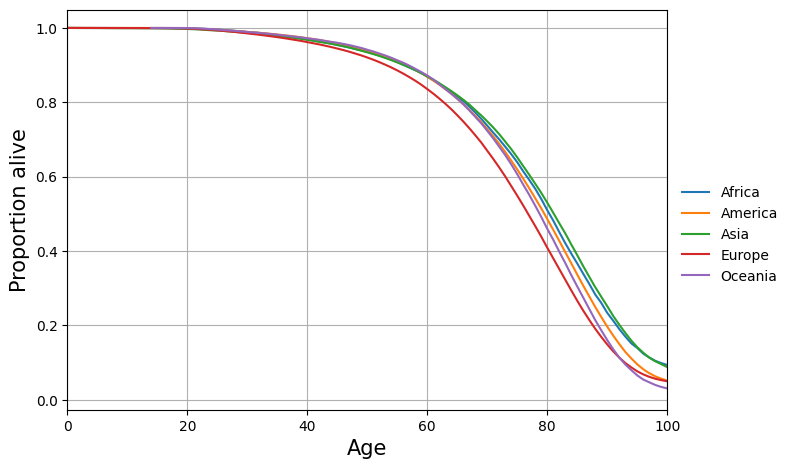

In [23]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("un_region"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.surv_prob, label=k)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Proportion alive", size=15)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

The results above may be heavily influenced by confounding.  The people from Oceania tended to live more recently, and people who lived more recently tend to have longer lifespans.  Conversely, many of the notable people from the 1500's-1700's are from Europe, and lifespans tended to be shorter in these historical eras. Looking at one factor at a time, it is not clear whether the "driver" of lifespan variation is geography (where a person lived) or time (when a person lived).

## Marginal hazard functions

A very important concept in survival analysis is the hazard function.  In this case, since the times are discrete (ages are in whole years), we can estimate the hazard easily as the ratio of the number of events (deaths) to the number at risk, for each age.  These are plotted below, stratified by era.

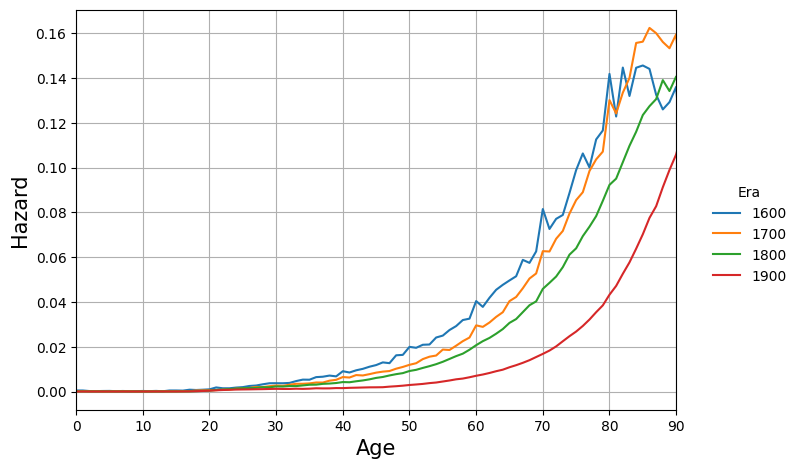

In [24]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("era"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    la = "%.0f" % (1600 + k*100)
    plt.plot(sf.surv_times, sf.n_events/sf.n_risk, label=la)
plt.xlabel("Age", size=15)
plt.ylabel("Hazard", size=15)
plt.xlim(0, 90)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right", title="Era")
leg.draw_frame(False)

Below we estimate and plot the (marginal) hazard function for each region.

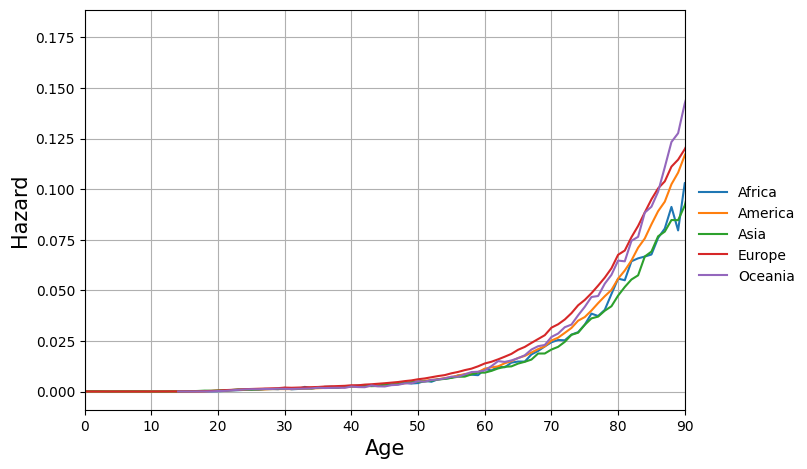

In [25]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("un_region"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.n_events/sf.n_risk, label=k)
plt.xlabel("Age", size=15)
plt.ylabel("Hazard", size=15)
plt.xlim(0, 90)
ha, lb = plt.gca().get_legend_handles_labels()
leg = plt.figlegend(ha, lb, loc="right")
leg.draw_frame(False)

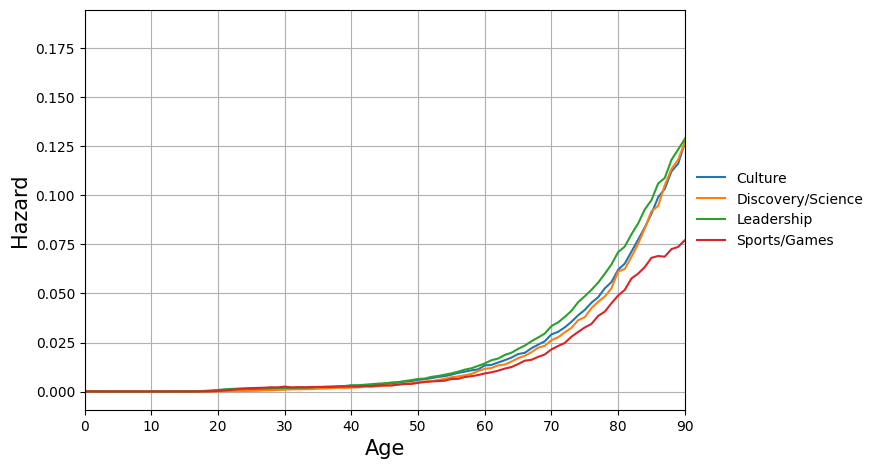

In [26]:
plt.figure(figsize=(8, 5))
plt.clf()
plt.axes([0.1, 0.1, 0.75, 0.8])
plt.grid(True)
for k,g in dx.groupby("level1_main_occ"):
    sf = sm.SurvfuncRight(g.clifespan, g.died)
    plt.plot(sf.surv_times, sf.n_events/sf.n_risk, label=k)
plt.xlabel("Age", size=15)
plt.ylabel("Hazard", size=15)
plt.xlim(0, 90)
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5), frameon=False)
leg.draw_frame(False)

## Proportional hazard modeling

Create a translated birth year setting year 1600 as year zero.  This makes it easier to interpret the proportional hazard regression models so that effects are relative to 1500 as a reference year.

In [27]:
dx["birth1600"] = dx["birth"] - 1600

Fit a proportional hazards regression model

In [28]:
fml = "clifespan ~ birth1600 + level1_main_occ + un_region"
m0 = sm.PHReg.from_formula(fml, dx, status="died")
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: PHReg
============================================================================================
Model:                            PH Reg                  Sample size:               1293384
Dependent variable:               clifespan               Num. events:               883057 
Ties:                             Breslow                                                   
--------------------------------------------------------------------------------------------
                                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science] -0.1093    0.0032 0.8964  -34.1796 0.0000 0.8908 0.9021
level1_main_occ[T.Leadership]        -0.0165    0.0026 0.9836   -6.3580 0.0000 0.9787 0.9887
level1_main_occ[T.Sports/Games]      -0.2065    0.0036 0.8134  -58.1644 0.0000 0.8077 0.8191
un_region[T.America]                 -0.0038    0.0097 0.9962   -0.3925 0.6947 0.9774 1.0153
un_region[T.Asia]                    -0.0908    0.0106 0.9132   -8.5701 0.0000 0.8944 0.9323
un_region[T.Europe]                   0.0240    0.0096 1.0243    2.5040 0.0123 1.0052 1.0438
un_region[T.Oceania]                  0.1290    0.0111 1.1377   11.6329 0.0000 1.1133 1.1627
birth1600                            -0.0055    0.0000 0.9945 -381.4402 0.0000 0.9945 0.9945
============================================================================================
Confidence intervals are for the hazard ratios
"""

We use partial regression plots to visualize the fitted model.  The function implemented below plots the partial effect of birth year on the log hazard.

In [29]:
def plot_birthyear_partial(dx, rr):
    dp = dx.iloc[0:100, :].copy()
    
    dp["level1_main_occ"] = "Culture"   
    dp["un_region"] = "Europe"       
    
    # 设置出生年份范围
    dp["birth"] = np.linspace(1600, 1960, 100)
    dp["birth1600"] = dp["birth"] - 1600 
    
    # 计算 log hazard 贡献
    lhr = rr.predict(exog=dp).predicted_values

    # 绘图
    plt.clf()
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.plot(dp["birth"].values, lhr, color="blue", linewidth=2)
    plt.xlabel("Birth year", fontsize=14)
    plt.ylabel("Contribution to the log hazard", fontsize=14)
    plt.title("Effect of Birth Year on Log Hazard", fontsize=16)
    plt.show()


In the first model, there is a linear main effect for birth year.  The hazard of death is decreasing as year of birth increases.

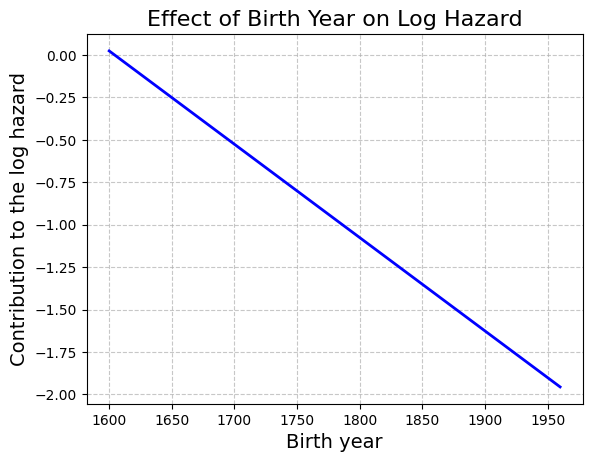

In [30]:
plot_birthyear_partial(dx, r0)

Next we include a quadratic effect for birth year, to see if the relationship between year of birth and log mortality hazard might be curved (parabolic), holding all other variables fixed. 

In [31]:
fml = "clifespan ~ birth1600 + I(birth1600**2) + level1_main_occ + un_region"
m1 = sm.PHReg.from_formula(fml, dx, status="died")
r1 = m1.fit()
r1.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: PHReg
============================================================================================
Model:                            PH Reg                  Sample size:               1293384
Dependent variable:               clifespan               Num. events:               883057 
Ties:                             Breslow                                                   
--------------------------------------------------------------------------------------------
                                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science] -0.1340    0.0032 0.8746  -41.8664 0.0000 0.8691 0.8801
level1_main_occ[T.Leadership]        -0.0737    0.0026 0.9290  -28.2131 0.0000 0.9242 0.9337
level1_main_occ[T.Sports/Games]      -0.1754    0.0036 0.8391  -49.2955 0.0000 0.8333 0.8450
un_region[T.America]                 -0.1140    0.0097 0.8922  -11.7452 0.0000 0.8754 0.9094
un_region[T.Asia]                    -0.1089    0.0106 0.8968  -10.2793 0.0000 0.8784 0.9156
un_region[T.Europe]                  -0.0893    0.0096 0.9146   -9.2866 0.0000 0.8975 0.9320
un_region[T.Oceania]                 -0.0047    0.0111 0.9953   -0.4226 0.6726 0.9739 1.0172
birth1600                             0.0094    0.0001 1.0094  118.6536 0.0000 1.0093 1.0096
I(birth1600 ** 2)                    -0.0000    0.0000 1.0000 -199.8683 0.0000 1.0000 1.0000
============================================================================================
Confidence intervals are for the hazard ratios
"""

Since the quadratic term for year of birth is statistically significant, there is evidence for curvature in the relationship between birth year and mortality hazard.  However this model could be mis-specified -- the true relationship might be non-quadratic.

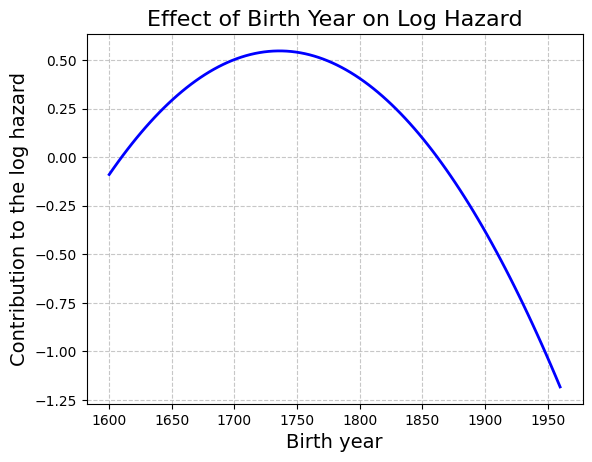

In [32]:
plot_birthyear_partial(dx, r1)

Next we add a cubic term to the model.

In [33]:
fml = "clifespan ~ birth1600 + I(birth1600**2) + I(birth1600**3) + level1_main_occ + un_region"
m2 = sm.PHReg.from_formula(fml, dx, status="died")
r2 = m2.fit()
r2.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: PHReg
============================================================================================
Model:                            PH Reg                  Sample size:               1293384
Dependent variable:               clifespan               Num. events:               883057 
Ties:                             Breslow                                                   
--------------------------------------------------------------------------------------------
                                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science] -0.1362    0.0032 0.8726  -42.5676 0.0000 0.8672 0.8781
level1_main_occ[T.Leadership]        -0.0660    0.0026 0.9361  -25.3042 0.0000 0.9313 0.9409
level1_main_occ[T.Sports/Games]      -0.1782    0.0036 0.8368  -50.1006 0.0000 0.8310 0.8426
un_region[T.America]                 -0.1467    0.0097 0.8636  -15.0990 0.0000 0.8473 0.8802
un_region[T.Asia]                    -0.1294    0.0106 0.8786  -12.2112 0.0000 0.8605 0.8970
un_region[T.Europe]                  -0.1184    0.0096 0.8883  -12.3144 0.0000 0.8717 0.9052
un_region[T.Oceania]                 -0.0565    0.0111 0.9451   -5.0830 0.0000 0.9247 0.9659
birth1600                            -0.0128    0.0002 0.9873  -67.8588 0.0000 0.9869 0.9876
I(birth1600 ** 2)                     0.0001    0.0000 1.0001   88.8502 0.0000 1.0001 1.0001
I(birth1600 ** 3)                    -0.0000    0.0000 1.0000 -120.9503 0.0000 1.0000 1.0000
============================================================================================
Confidence intervals are for the hazard ratios
"""

Based on this model, the mortality hazard was fairly constant until around 1800, then it began to drop.

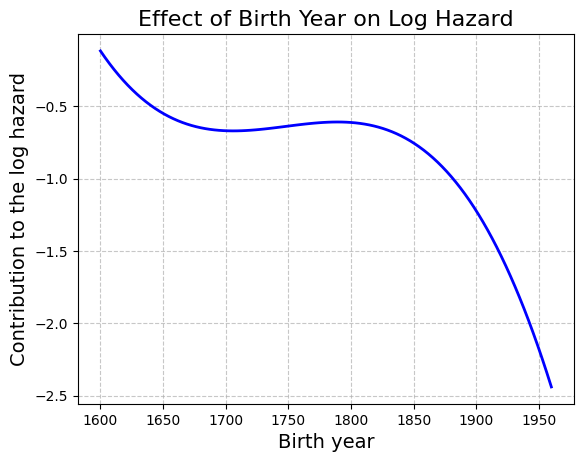

In [34]:
plot_birthyear_partial(dx, r2)

High order polynomials make poor basis functions.  A more effective approach is polynomial splines, which are piecewise polynomials.  Below we use a cubic spline basis with four degrees of freedom to capture the birth year effect.

In [35]:
fml = "clifespan ~ bs(birth1600, 4) + level1_main_occ + un_region"
m3 = sm.PHReg.from_formula(fml, dx, status="died")
r3 = m3.fit()
r3.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                       Results: PHReg
============================================================================================
Model:                            PH Reg                  Sample size:               1293384
Dependent variable:               clifespan               Num. events:               883057 
Ties:                             Breslow                                                   
--------------------------------------------------------------------------------------------
                                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
--------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science] -0.1362    0.0032 0.8727  -42.5437 0.0000 0.8672 0.8782
level1_main_occ[T.Leadership]        -0.0654    0.0026 0.9367  -25.0426 0.0000 0.9320 0.9415
level1_main_occ[T.Sports/Games]      -0.1786    0.0036 0.8365  -50.1997 0.0000 0.8307 0.8423
un_region[T.America]                 -0.1469    0.0097 0.8633  -15.1289 0.0000 0.8471 0.8799
un_region[T.Asia]                    -0.1305    0.0106 0.8777  -12.3109 0.0000 0.8596 0.8961
un_region[T.Europe]                  -0.1188    0.0096 0.8879  -12.3563 0.0000 0.8714 0.9048
un_region[T.Oceania]                 -0.0562    0.0111 0.9453   -5.0596 0.0000 0.9249 0.9661
bs(birth1600, 4)[0]                  -1.2686    0.0215 0.2812  -59.0333 0.0000 0.2696 0.2933
bs(birth1600, 4)[1]                   0.6458    0.0107 1.9076   60.3429 0.0000 1.8680 1.9480
bs(birth1600, 4)[2]                  -1.8620    0.0117 0.1554 -158.6381 0.0000 0.1518 0.1590
bs(birth1600, 4)[3]                  -2.3900    0.0140 0.0916 -171.1616 0.0000 0.0892 0.0942
============================================================================================
Confidence intervals are for the hazard ratios
"""

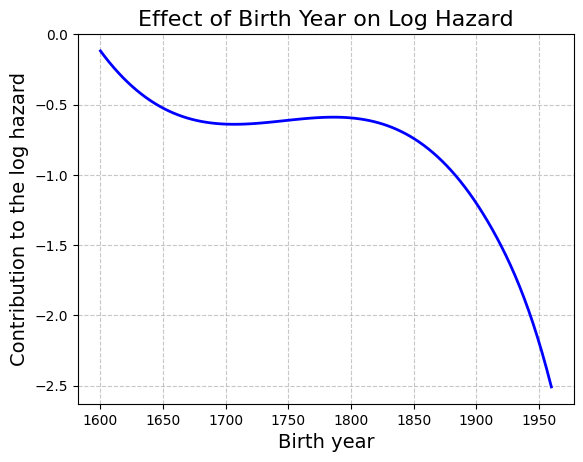

In [36]:
plot_birthyear_partial(dx, r3)

Above we found that year of birth is a strong predictor of the mortality hazard.  We also have a strong sex difference, with males having a much greater hazard.  Next we consider whether the year of birth effect differs by sex.

In [37]:
fml = "clifespan ~ bs(birth1600, 4) * level1_main_occ + un_region"
m4 = sm.PHReg.from_formula(fml, dx, status="died")
r4 = m4.fit()
r4.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                Results: PHReg
===============================================================================================================
Model:                                   PH Reg                        Sample size:                     1293384
Dependent variable:                      clifespan                     Num. events:                     883057 
Ties:                                    Breslow                                                               
---------------------------------------------------------------------------------------------------------------
                                                          log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science]                      0.0210    0.0321 1.0212   0.6547 0.5126 0.9590 1.0875
level1_main_occ[T.Leadership]                             0.2083    0.0237 1.2316   8.7815 0.0000 1.1756 1.2902
level1_main_occ[T.Sports/Games]                           0.1720    0.2410 1.1877   0.7136 0.4754 0.7406 1.9047
un_region[T.America]                                     -0.1499    0.0097 0.8608 -15.4120 0.0000 0.8445 0.8774
un_region[T.Asia]                                        -0.1330    0.0106 0.8755 -12.5431 0.0000 0.8575 0.8939
un_region[T.Europe]                                      -0.1222    0.0096 0.8850 -12.6972 0.0000 0.8684 0.9018
un_region[T.Oceania]                                     -0.0605    0.0111 0.9413  -5.4405 0.0000 0.9210 0.9620
bs(birth1600, 4)[0]                                      -0.9154    0.0402 0.4004 -22.7522 0.0000 0.3700 0.4332
bs(birth1600, 4)[1]                                       0.7126    0.0195 2.0392  36.6236 0.0000 1.9629 2.1185
bs(birth1600, 4)[2]                                      -1.6530    0.0216 0.1915 -76.5916 0.0000 0.1835 0.1997
bs(birth1600, 4)[3]                                      -1.9261    0.0234 0.1457 -82.2156 0.0000 0.1392 0.1526
bs(birth1600, 4)[0]:level1_main_occ[T.Discovery/Science] -0.1335    0.0668 0.8750  -1.9998 0.0455 0.7677 0.9973
bs(birth1600, 4)[1]:level1_main_occ[T.Discovery/Science]  0.0913    0.0326 1.0956   2.8047 0.0050 1.0279 1.1679
bs(birth1600, 4)[2]:level1_main_occ[T.Discovery/Science] -0.2627    0.0363 0.7690  -7.2269 0.0000 0.7161 0.8258
bs(birth1600, 4)[3]:level1_main_occ[T.Discovery/Science] -0.9121    0.0456 0.4017 -20.0126 0.0000 0.3673 0.4392
bs(birth1600, 4)[0]:level1_main_occ[T.Leadership]        -0.4906    0.0504 0.6122  -9.7337 0.0000 0.5547 0.6758
bs(birth1600, 4)[1]:level1_main_occ[T.Leadership]        -0.2041    0.0249 0.8154  -8.1884 0.0000 0.7765 0.8562
bs(birth1600, 4)[2]:level1_main_occ[T.Leadership]        -0.2301    0.0273 0.7945  -8.4344 0.0000 0.7531 0.8381
bs(birth1600, 4)[3]:level1_main_occ[T.Leadership]        -1.0839    0.0343 0.3383 -31.6372 0.0000 0.3163 0.3618
bs(birth1600, 4)[0]:level1_main_occ[T.Sports/Games]      -2.1569    0.3322 0.1157  -6.4926 0.0000 0.0603 0.2218
bs(birth1600, 4)[1]:level1_main_occ[T.Sports/Games]       0.1991    0.2249 1.2203   0.8850 0.3762 0.7852 1.8963
bs(birth1600, 4)[2]:level1_main_occ[T.Sports/Games]      -0.4531    0.2446 0.6357  -1.8525 0.0640 0.3936 1.0266
bs(birth1600, 4)[3]:level1_main_occ[T.Sports/Games]      -0.3260    0.2399 0.7218  -1.3589 0.1742 0.4510 1.1551
===============================================================================================================
Confidence intervals are for the hazard ratios
"""

To assess whether the birthyear x gender interaction is significant, we can use a log-likelihood ratio test:

In [38]:
stat = 2*(r4.llf - r3.llf)
dof = len(r4.params) - len(r3.params)
print("stat=", stat)
print("dof=", dof)
1 - chi2(dof).cdf(stat)

stat= 2772.3578174971044
dof= 12


np.float64(0.0)

In [39]:
dx['un_region'].value_counts()

un_region
Europe     779447
America    363808
Asia        82162
Oceania     45098
Africa      22869
Name: count, dtype: int64

To understand the meaning of the interaction, we plot below the sex-specific contributions of year of birth to the log hazard.

In [40]:
def plot_birthyear_partial_occ(dx, rr):
    occ_list = ["Culture", "Discovery/Science", "Leadership", "Sports/Games"]
    b = np.linspace(1600, 1960, 100)

    plt.figure(figsize=(8, 5))
    plt.grid(True, linestyle="--", alpha=0.7)

    for occ in occ_list:
        dp = dx.iloc[0:100, :].copy()
        dp["level1_main_occ"] = occ
        dp["un_region"] = "Europe"   # 固定区域
        dp["birth"] = b
        dp["birth1600"] = dp["birth"] - 1600

        lhr = rr.predict(exog=dp).predicted_values
        plt.plot(dp["birth"].values, lhr, label=occ)

    plt.xlabel("Birth year", fontsize=14)
    plt.ylabel("Contribution to the log hazard", fontsize=14)
    plt.title("Effect of Birth Year by Occupation", fontsize=16)
    plt.legend(title="Occupation", loc="center left", bbox_to_anchor=(1, 0.5))
    plt.tight_layout()
    plt.show()


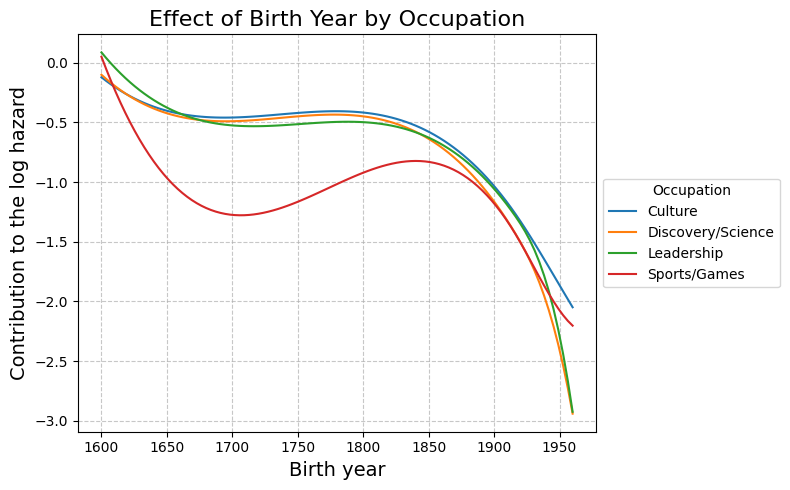

In [41]:
plot_birthyear_partial_occ(dx, r4)

Above we considered an interaction between a categorical variable (gender) and a quantitative variable (birth1500).  Since the quantitative variable was modeled with splines, this createst an interaction between the gender indicator and each basis function of birth1500.  A more parsimonious way to model interactions involving splines is to model that main effect with a spline, but use only linear terms for the interaction.  This technique is illustrated below.

In [42]:
fml = "clifespan ~ bs(birth1600, 4) + level1_main_occ + birth1600:level1_main_occ + un_region"
m5 = sm.PHReg.from_formula(fml, dx, status="died")
r5 = m5.fit()
r5.summary()

/Users/jiatao/miniforge3/envs/clinical/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/jiatao/miniforge3/envs/clinical/lib/python3.11/site-packages/statsmodels/duration/hazard_regression.py:1423: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
                                          Results: PHReg
===================================================================================================
Model:                               PH Reg                    Sample size:                 1293384
Dependent variable:                  clifespan                 Num. events:                 883057 
Ties:                                Breslow                                                       
---------------------------------------------------------------------------------------------------
                                              log HR log HR SE   HR      t     P>|t|  [0.025 0.975]
---------------------------------------------------------------------------------------------------
level1_main_occ[T.Discovery/Science]          0.1857    0.0133 1.2041  13.9631 0.0000 1.1731 1.2359
level1_main_occ[T.Leadership]                 0.0396    0.0104 1.0404   3.8169 0.0001 1.0195 1.0618
level1_main_occ[T.Sports/Games]              -0.6280    0.0331 0.5336 -18.9962 0.0000 0.5002 0.5694
un_region[T.America]                         -0.1478    0.0097 0.8626 -15.2064 0.0000 0.8463 0.8792
un_region[T.Asia]                            -0.1297    0.0106 0.8783 -12.2369 0.0000 0.8603 0.8968
un_region[T.Europe]                          -0.1186    0.0096 0.8881 -12.3273 0.0000 0.8716 0.9051
un_region[T.Oceania]                         -0.0558    0.0111 0.9458  -5.0163 0.0000 0.9254 0.9666
bs(birth1600, 4)[0]                          -0.7880       nan 0.4548      nan    nan    nan    nan
bs(birth1600, 4)[1]                           1.7648       nan 5.8407      nan    nan    nan    nan
bs(birth1600, 4)[2]                          -0.2048       nan 0.8148      nan    nan    nan    nan
bs(birth1600, 4)[3]                          -0.6765       nan 0.5084      nan    nan    nan    nan
birth1600:level1_main_occ[Culture]           -0.0045       nan 0.9955      nan    nan    nan    nan
birth1600:level1_main_occ[Discovery/Science] -0.0056       nan 0.9944      nan    nan    nan    nan
birth1600:level1_main_occ[Leadership]        -0.0048       nan 0.9952      nan    nan    nan    nan
birth1600:level1_main_occ[Sports/Games]      -0.0030       nan 0.9970      nan    nan    nan    nan
===================================================================================================
Confidence intervals are for the hazard ratios
"""

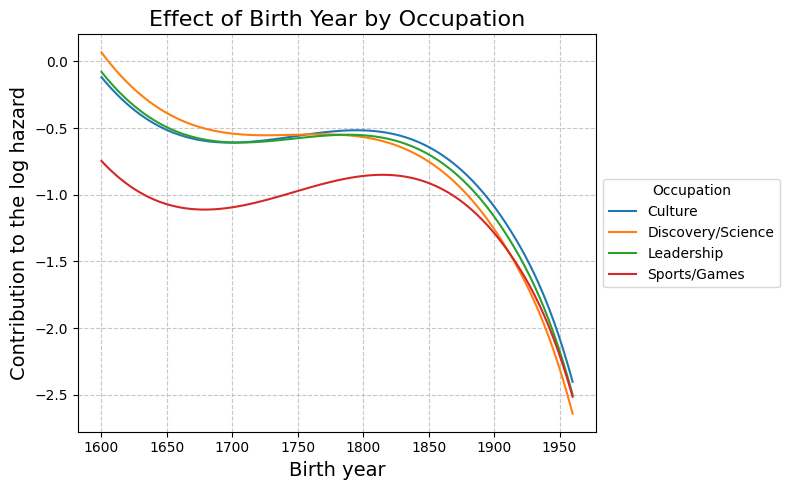

In [43]:
plot_birthyear_partial_occ(dx, r5)

## Baseline hazard functions

The estimated baseline cumulative hazard function reflects the age-specific hazard of death, controlling for all covariates in the model.  The  cumulative hazard is easy to estimate but not straightforward to interpret.

Text(0, 0.5, 'Cumulative hazard')

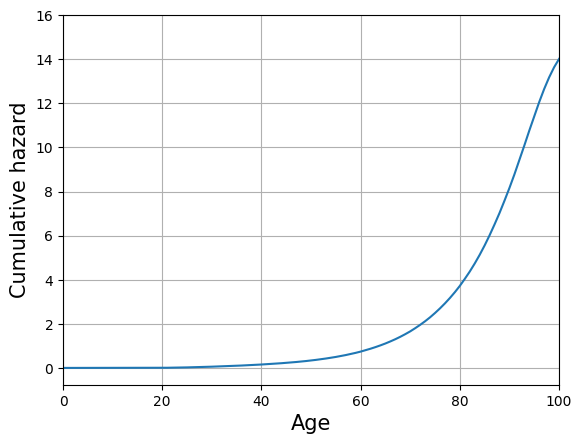

In [44]:
ti, cumhaz, surv = r0.baseline_cumulative_hazard[0]

plt.clf()
plt.grid(True)
plt.plot(ti, cumhaz)
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Cumulative hazard", size=15)

Estimate and plot the baseline cumulative hazard function on the log scale

Text(0, 0.5, 'Log cumulative hazard')

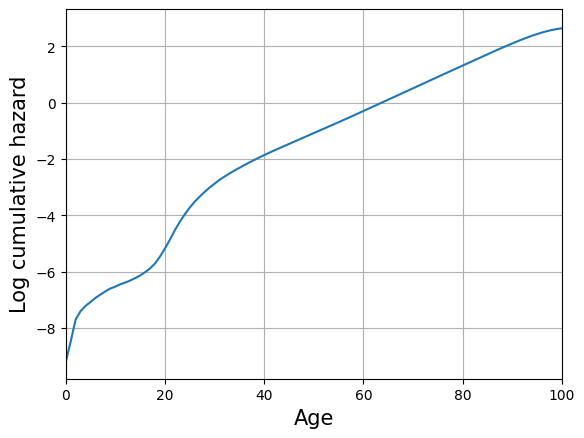

In [45]:
ti, cumhaz, surv = r0.baseline_cumulative_hazard[0]

plt.clf()
plt.grid(True)
plt.plot(ti, np.log(np.clip(cumhaz, 1e-4, np.inf)))
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("Log cumulative hazard", size=15)

Next we estimate and plot the baseline hazard function using numerical differentiation

Text(0, 0.5, 'log hazard')

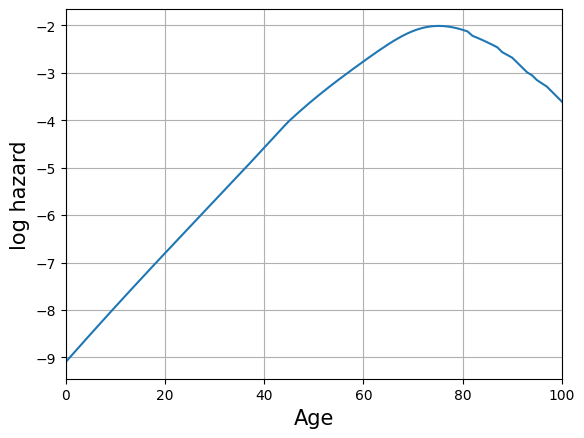

In [46]:
ti, chaz, surv = r0.baseline_cumulative_hazard[0]
haz = np.diff(chaz) / np.diff(ti)
shaz = sm.nonparametric.lowess(np.log(haz), ti[0:-1])

plt.clf()
plt.grid(True)
plt.plot(shaz[:, 0], shaz[:, 1])
plt.xlim(0, 100)
plt.xlabel("Age", size=15)
plt.ylabel("log hazard", size=15)

# Stratification

Fit a sex-stratified proportional hazards regression model

In [47]:
fml = "clifespan ~ bs(birth, 4) + un_region"
m6 = sm.PHReg.from_formula(fml, dx, status="died", strata="level1_main_occ")
r6 = m6.fit()
r6.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: PHReg
============================================================================
Model:                      PH Reg          Num strata:             4       
Dependent variable:         clifespan       Min stratum size:       212177  
Ties:                       Breslow         Max stratum size:       441636  
Sample size:                1293384         Avg stratum size:       323346.0
Num. events:                883057                                          
----------------------------------------------------------------------------
                      log HR log HR SE   HR       t     P>|t|  [0.025 0.975]
----------------------------------------------------------------------------
un_region[T.America] -0.1527    0.0097 0.8584  -15.7189 0.0000 0.8422 0.8749
un_region[T.Asia]    -0.1313    0.0106 0.8770  -12.3830 0.0000 0.8590 0.8954
un_region[T.Europe]  -0.1148    0.0096 0.8916  -11.9346 0.0000 0.8749 0.9085
un_region[T.Oceania] -0.0751    0.0111 0.9277   -6.7504 0.0000 0.9077 0.9481
bs(birth, 4)[0]      -1.2466    0.0215 0.2875  -58.0492 0.0000 0.2756 0.2998
bs(birth, 4)[1]       0.6655    0.0107 1.9454   62.1360 0.0000 1.9050 1.9867
bs(birth, 4)[2]      -1.8574    0.0117 0.1561 -158.3240 0.0000 0.1525 0.1597
bs(birth, 4)[3]      -2.4204    0.0140 0.0889 -173.0045 0.0000 0.0865 0.0914
============================================================================
Confidence intervals are for the hazard ratios
"""

Plot the estimated baseline hazard function for each sex:

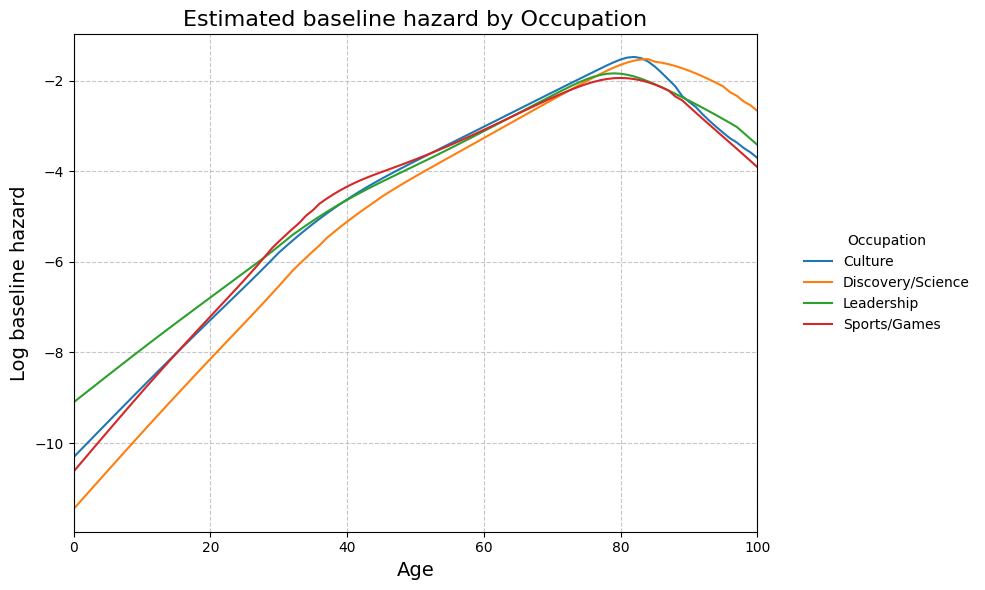

In [48]:
bh = r6.baseline_cumulative_hazard
snames = m6.surv.stratum_names  

plt.figure(figsize=(10, 6))
plt.grid(True, linestyle="--", alpha=0.7)

for k in range(len(snames)):
    ti = bh[k][0]     # 时间点 (age)
    chaz = bh[k][1]   # 累积 hazard
    # 数值微分估计 baseline hazard
    haz = np.diff(chaz) / np.diff(ti)
    # 用 lowess 平滑并取对数
    shaz = sm.nonparametric.lowess(np.log(haz), ti[:-1], frac=0.5)
    plt.plot(shaz[:, 0], shaz[:, 1], label=snames[k])

plt.xlabel("Age", fontsize=14)
plt.ylabel("Log baseline hazard", fontsize=14)
plt.title("Estimated baseline hazard by Occupation", fontsize=16)
plt.xlim(0, 100)
plt.legend(title="Occupation", bbox_to_anchor=(1.05, 0.5), loc="center left", frameon=False)
plt.tight_layout()
plt.show()
